In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

### Сгенерируем синус, наложим нормальный шум и добавим линейный тренд, а также поделим выборку на тренировочную и тестовую

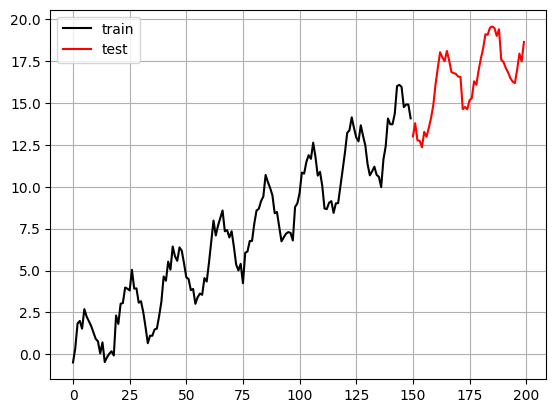

In [2]:
x = np.linspace(0, 20*np.pi, 200)
y = 2*np.sin(x) + 0.3*x +  np.random.randn(200)*0.5
sin_df = pd.DataFrame({'sinx': y})
train = sin_df[:150]
test = sin_df[150:]
plt.plot(train, color = "black", label ='train')
plt.plot(test, color = "red", label = 'test')
plt.legend()
plt.grid()
plt.show()

### Проверим временной ряд на стационарность при помощи теста Дики-Фуллера

In [3]:
def check_adfuller(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

check_adfuller(train)

Test statistic:  -0.11186845387517103
p-value:  0.9482434832527361
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


### Так как значение статистики больше чем критические значения на 1%, 5% и 10%, то ряд является нестационарным

### Таким образом, модель ARMA нам не подходит, так как она работает со стационарными временными рядами, а модель ARIMA, так как работает без учета сезонности, поэтому будем рассматривать модель SARIMA - подберём её параметры p, d, q (SARIMAX не используем, так как нет экзогенных факторов)

### Можно заметить, что хватит 1-го порядка дифференцирования, для того чтобы получить стационарный ряд, второе уже имеет много шумов, соответственно берем d равное 1 (на всякий случай проведем тест Дики-Фуллера)

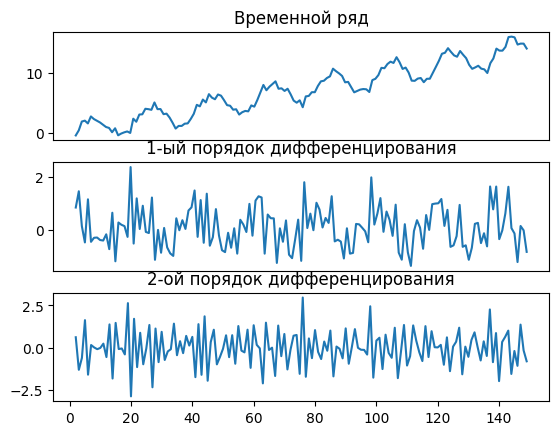

In [4]:
data = sin_df['sinx']
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(train)
ax1.set_title('Временной ряд')
ax1.axes.xaxis.set_visible(False)

ax2.plot(train.diff().dropna())
ax2.set_title('1-ый порядок дифференцирования')
ax2.axes.xaxis.set_visible(False)

ax3.plot(train.diff().diff().dropna())
ax3.set_title('2-ой порядок дифференцирования')
plt.show()

### Ряд стационарен при d = 1

In [5]:
check_adfuller(train.diff().dropna())

Test statistic:  -9.3958753771064
p-value:  6.376763972770568e-16
Critical Values: {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}


### Для того чтобы найти оптимальные параметры p, q, отвечающие за количество входящих в линейную комбинацию предыдущих значений и ошибок соответственно, необходимо построить графики PACF и ACF

### На графике PACF нужно найти лаг, на котором происходит резкое падение корреляции, а на ACF, лаг, на котором начинается спад корреляции

### p  = 2, q = 1

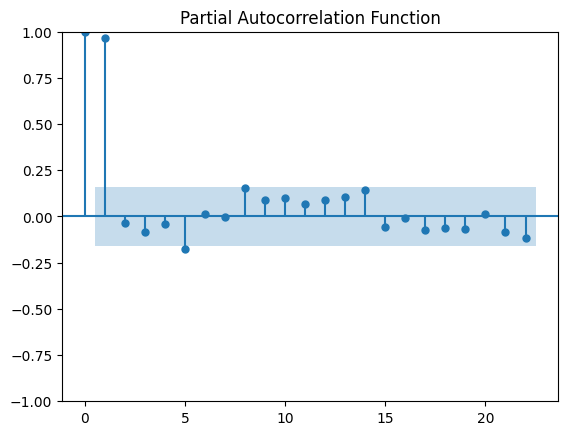

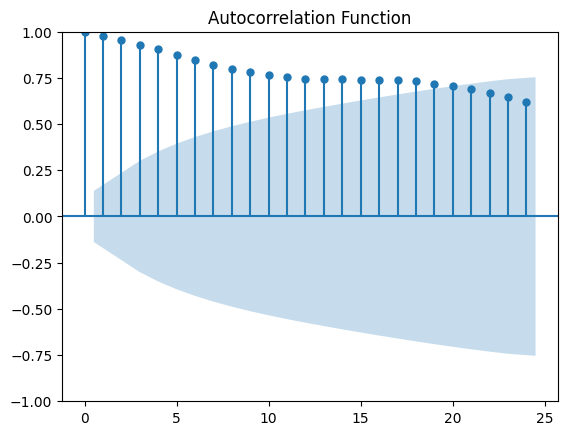

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(train, title='Partial Autocorrelation Function')
plt.show()
plot_acf(data,  title='Autocorrelation Function')
plt.show()

### Так как мы не знаем сезонность, мы можем найти её преобразовав индексы в даты, чтобы воспользоваться функцией seasonal_decompose

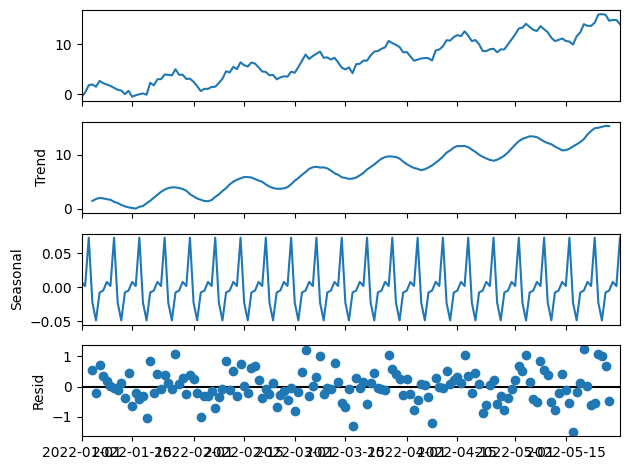

In [7]:
integer_range = range(0,150)
start_date = pd.Timestamp('2022-01-01')
date_range = [start_date + pd.DateOffset(days=i) for i in integer_range]

decompose_train = pd.DataFrame({'ds': date_range, 'y': y[:150]}).set_index('ds')
decompose = seasonal_decompose(decompose_train)
decompose.plot()

plt.show()

### Можно заметить, что сезонность равна 20 (значения начинают повторять через 20 отсчетов)

In [8]:
decompose.seasonal[:25]


ds
2022-01-01    0.008024
2022-01-02    0.001997
2022-01-03    0.072855
2022-01-04   -0.022355
2022-01-05   -0.048370
2022-01-06   -0.007471
2022-01-07   -0.004680
2022-01-08    0.008024
2022-01-09    0.001997
2022-01-10    0.072855
2022-01-11   -0.022355
2022-01-12   -0.048370
2022-01-13   -0.007471
2022-01-14   -0.004680
2022-01-15    0.008024
2022-01-16    0.001997
2022-01-17    0.072855
2022-01-18   -0.022355
2022-01-19   -0.048370
2022-01-20   -0.007471
2022-01-21   -0.004680
2022-01-22    0.008024
2022-01-23    0.001997
2022-01-24    0.072855
2022-01-25   -0.022355
Name: seasonal, dtype: float64

### Возьмем в качестве базового решения наивный предсказатель, который предсказывает предыдущую сезонность, а также учитывает разницу средних значений соседних циклов 

In [9]:
class NaiveSeasonality():
    def __init__(self, seasonality):
        self.seasonality = seasonality
        self.trend = None
        self.last_season = None
    def fit(self, train):
        self.trend = train['sinx'].iloc[-self.seasonality:].mean() - train['sinx'].iloc[- 2* self.seasonality: -self.seasonality].mean()
        self.last_season = train['sinx'].iloc[-self.seasonality:].tolist()
    def predict(self, indices):
        pred = []
        for i in range(len(indices)):
            pred.append(self.last_season[i % len(self.last_season)] + (i//len(self.last_season)+1)*(self.trend))
        return pd.DataFrame({'indices': indices, 'y_pred': pred}).set_index('indices')

### Для сравнения различных моделей мы будем использовать метрику MAPE, так как она не зависит от шкалы значений во временном ряде и показывает относительную абсолютную ошибку. Это может быть не так полезно в текущей задаче, но в принципе является достаточно объективной метрикой, например, при переходе от дневных к часовых данным, где шкала значений может меняться

MAPE: 0.037432391759075805


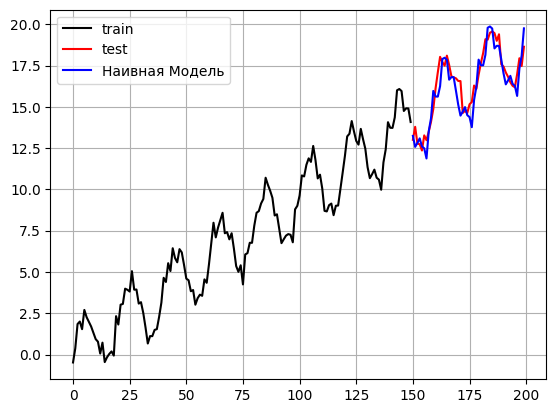

In [10]:
from sklearn.metrics import mean_absolute_percentage_error
metrics_dict = {}

forecaster = NaiveSeasonality(seasonality=20)
forecaster.fit(train)
pred = forecaster.predict(np.arange(150,200))
mape = mean_absolute_percentage_error(test, pred)
metrics_dict['Наивный предсказатель'] = mape
print("MAPE:", mape)

plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(pred, color = "blue", label = 'Наивная Модель')
plt.grid()
plt.legend()

plt.show()

### Модель SARIMA

MAPE: 0.026996525196464772


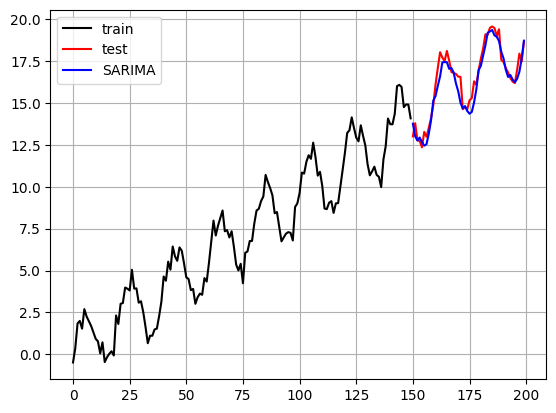

In [11]:
model = ARIMA(train, seasonal_order=(2,1,1, 20), trend='t')
model_fit = model.fit()

pred = model_fit.predict(start=150, end=199)
mape =mean_absolute_percentage_error(test, pred)
metrics_dict['SARIMA'] = mape

print("MAPE:", mape)

plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(pred, color = "blue", label = 'SARIMA')
plt.grid()
plt.legend()

plt.show()

### Для модели Prophet от Facebook также необходимо преобразовать индексы в даты 

c:\Users\kirillwin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
05:39:58 - cmdstanpy - INFO - Chain [1] start processing
05:39:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.026308445244282167


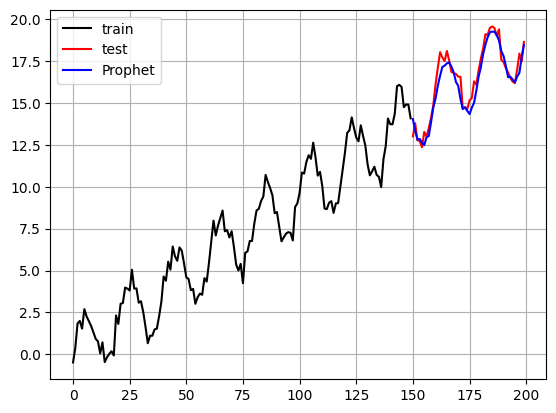

In [12]:
from prophet import Prophet

prophet_train = pd.DataFrame({'ds': date_range, 'y': y[:150]})
m = Prophet()
m.add_seasonality(name ='a', period=20, fourier_order=100)
m.fit(prophet_train)
future = m.make_future_dataframe(periods=50) # т.к. тест размера 50
pred = m.predict(future)
pred = pred['yhat'][150:]

mape = mean_absolute_percentage_error(test, pred)
metrics_dict['Prophet'] = mape

print("MAPE:", mape)

plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(pred, color = "blue", label = 'Prophet')
plt.grid()
plt.legend()

plt.show()

### Экспоненциальное сглаживание

MAPE: 0.026111926318940007


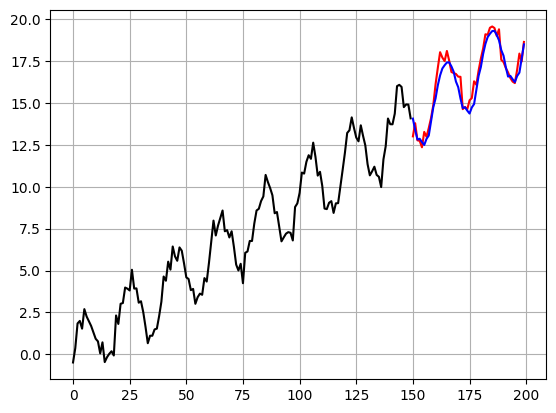

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=20)
fit = model.fit()

pred = fit.forecast(steps=50)

mape = mean_absolute_percentage_error(test, pred)
metrics_dict['Экспоненциальное сглаживание'] = mape

print("MAPE:", mape)

plt.plot(train, color = "black", label = 'train')
plt.plot(test, color = "red", label = 'test')
plt.plot(pred, color = "blue", label = 'Экспоненциальное сглаживание')
plt.grid()

plt.show()

In [14]:
print(metrics_dict)

{'Наивный предсказатель': 0.037432391759075805, 'SARIMA': 0.026996525196464772, 'Prophet': 0.026308445244282167, 'Экспоненциальное сглаживание': 0.026111926318940007}


### В данной задаче все модели превосходят наивный предсказатель, но все они решают эту задачу приблизительно одинаково, в зависимости от сида выигрывает та или иная модель. Для того чтобы выяснить какая модель лучше справляется, необходимо решить подобные задачи много раз, подбирать для каждой модели оптимальные гиперпараметры и усреднить метрики во всех задачах